In [1]:
import json
import os

data = {}
dataroot = "awe"
transl_file = "awe-translation.csv"

for i in range(1,101):
    with open(os.path.join(dataroot,str(i).zfill(3),"annotations.json")) as f:
        data[str(i).zfill(3)] = json.load(f)

In [2]:
test_files = []
train_files = []

import csv
with open(transl_file) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        if("train" in row[0]):
            train_files.append(row[1])
        elif("test" in row[0]):
            test_files.append(row[1])
            
print(len(test_files),len(train_files))
print(test_files[0])

250 750
011/07.png


In [3]:
#definition of our dataset. Returns images and annotations

from torch.utils.data import Dataset, DataLoader
from itertools import combinations,permutations
import random
from skimage import io, color
from skimage.transform import rescale
from skimage.util import pad
from torchvision import transforms
from torchvision.transforms.functional import pad

imgsize = 128

class EarDataset(Dataset):
    """Ear dataset."""
    
    
    def __init__(self, root_dir, data, validation=False):

        #self.data = data
        #self.dataroot = root_dir
        
        self.data = []
        self.annots_gender = []
        self.annots_ethn = []
        self.annots_id = []
        
        if validation:
            filenames = test_files
        else:
            filenames = train_files
        
        for i in filenames:
            self.data.append(os.path.join(root_dir,i))
            #print(i.split("/")[0])
            with open(os.path.join(root_dir,i.split("/")[0],"annotations.json")) as f:
                annotdata = json.load(f)
            self.annots_gender.append([0 if annotdata["gender"]=="m" else 1])
            ethn = annotdata["ethnicity"]
            if ethn == 99:
                ethn = 0
            self.annots_ethn.append(ethn)
            self.annots_id.append(int(i.split("/")[0])-1)
        
        #print(len(self.data))
        #print(self.annots_gender)
        print(len(np.unique(self.annots_id)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        image = io.imread(self.data[idx])
        #annot = self.annots_gender[idx]
        #annot = self.annots_ethn[idx]
        annot = self.annots_id[idx]

        if len(image.shape) == 2:
            image = color.gray2rgb(image)
        elif image.shape[2] == 4:
            image = image[:,:,:3]
    
        image = rescale(image,imgsize/image.shape[0],multichannel = True)
    
        return image_transform(image).type(torch.FloatTensor)[:,:,:128],annot
        
image_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Pad((0,0,128,0))
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
import torch
import numpy as np

dataset_train = EarDataset(dataroot,data,validation=False)
dataset_loader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=2, shuffle=True,
                                             num_workers=4)
dataset_test = EarDataset(dataroot,data,validation=True)
dataset_loader_valid = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=16, shuffle=False,
                                             num_workers=4)

100
99


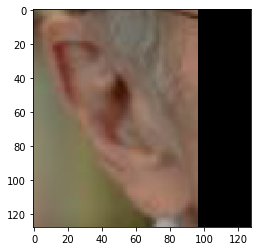

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for i in dataset_loader_train:
    #print(i[0].shape)
    plt.figure()
    plt.imshow(i[0][0].permute(1,2,0))
    break

In [6]:
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

#creating our model. we set the model and number of classes we want here

net = models.resnet34(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 100)
net.cuda()
#summary(resnet50,(3,128,60))

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [32]:
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score

losses_train = []
losses_valid = []
acc_train = []
acc_valid = []

max_acc = 0

def train_model(model, criterion, optimizer, num_epochs=2, validation=False):
    since = time.time()

    global max_acc
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            
            if phase == 'train':
                if validation:
                    continue
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            print("Starting phase: ", phase)
            losses = []   
            # Iterate over data.
            
            labels = []
            preds = []
            
            dataload = dataset_loader_train if phase == 'train' else dataset_loader_valid
            for stuff in tqdm(dataload):
                
                image, annot = stuff
                
                image = image.cuda()
                
                annot = annot.cuda()
                
                #print(annot)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(image)

                    #print(outputs.shape)
                    #print(annot.shape)
                    
                    #assert 0
                    
                    loss = criterion(outputs, annot)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    

                # statistics
                losses.append(loss.item()) #* images.size(0)
                
                annot = annot.cpu().detach().numpy()
                outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
                
                labels.append(annot)
                preds.append(outputs)
                
            epoch_loss = np.mean(losses)
            labels = np.concatenate(labels)
            preds = np.concatenate(preds)
            acc = accuracy_score(labels,preds)
                     
            if(phase == 'train'):
                losses_train.append(epoch_loss)
                acc_train.append(acc)
            else:
                losses_valid.append(epoch_loss)
                acc_valid.append(acc)
                if(acc > max_acc):
                    max_acc = acc
                    torch.save(model.state_dict(),"resnet34_2_id.pth")
            
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Accuracy {:.4f}'.format(
                phase, epoch_loss,acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(max_acc))

    return model

In [33]:
net = net.cuda()
net = train_model(net, criterion, optimizer, num_epochs=1,validation=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 0/0
----------
Starting phase:  valid


100%|██████████| 16/16 [00:00<00:00, 25.14it/s]


valid Loss: 3.1790 Accuracy 0.4400
Training complete in 0m 2s
Best val Acc: 0.440000


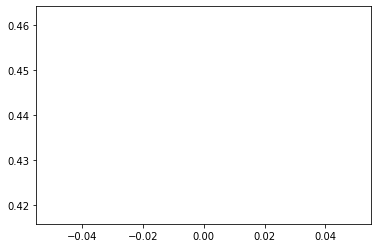

In [34]:
plt.plot(acc_valid)
plt.plot(acc_train)

In [67]:
from torchsummary import summary

summary(net, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,